In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import datetime as dt
import math
import missingno as msno
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import DateFormatter

In [2]:
pd.set_option('display.max_columns', None)

## Table of contents
1. [Importing data](#importing)
2. [Exploring attributes with regards to modelling](#exploring)
    1. [Correlations](#corr)
    2. [Supermarkets](#markets)
    3. [Domain knowledge - how to model the data](#domain)
    4. [Aggregating](#agg)
    5. [Visualising the data](#visual)
    6. [Considering time](#time)
3. [Pre-processing the data for modelling](#pre)
    1. [Aggregating](#agg2)
    2. [One-hot encoding](#onehot)
    3. [Normalising](#norm)

## Summary of model pre-processing:

**Removing data points**:
* I dropped all data points that occurred on the day of door seal change, as it is not known at what time the door seal was changed. It is also likely that this may be an unusual day in terms of measurement readings anyway.
* I chose to carry out the analysis only on the supermarkets 89020, 91728, 92232, 91777, 93593 and 94044, as they are either missing no data, or only less than 1% of the data.
* Heatpump group 91777.2.0 has chillingPower = 0 for almost the entire dataset. It is likely that this value is a proxy for NA. Therefore this heat pump group is dropped.

**Considering how to model the data**
* Plots showed that some variables, like humidity and outside temperatures show a clearly changing pattern over time. Because the before/after seal change attribute corresponds strongly to time passing, any model that tries to predict this variable (like logistic regression), will simply use the patterns over time inherent to variables like outsideTemperature to "predict the seal change". However this only reflects the passing of time, and does not say anything useful about the door seal change.
* I therefore take a different approach, based on considering the domain and mechanics of the real world problem. Compressing the air for the cooling system requires the most energy, and many factors affect how much energy is required:
    - Current temperature of inside of fridge (will change how much you need to cool it or not)
    - Humidity - because it changes the heat capacity of the air inside the fridge, therefore may need more/less energy to cool it.
        However humidity also affects how much heat gets taken off the compressed gas - so both can have opposite effects.
    - Outside temperatures, because it changes the effectiveness of taking heat off the compressed gas.
    - The door seal! Because a good door seal will mean the temperatures of all the different elements inside of the fridge is maintained.
        - & the interactions between these variables. For example, the humidity may modify the way that the door seal affects the heat transfer.  
    - The chiller power usage will likely change to reflect to the temperatures changing over the data's time period of November -> February. As the dataset only covers a very short amount of time, we can only model how the different features correspond to energy requirements during winter. Predictions based on observations made in summer will be extrapolating from outside of the dataset.
    - Plots showed that the relationships between the variables are different for each heat pump group. 

**Selecting relevant variables**
* Therefore my modelling approach will be to try to predict chilling power (representing the energy required to power the heat pump in kW), and thus the cost effectiveness of the system. The attributes used to predict chilling power will be attributes that are effectors directly changing how much energy is required for cooling (e.g. humidity, fridge temperatures). But there are also consequences (air stream and evaporator temperatures) - i.e. these temperatures are controlled by the heat pump, in response to variables like humidity, temperature, etc.
* The door seal change attribute will be included as an independent variable, to see whether it is an important feature in affecting the chilling power required.
* Based on visual plots, no single variable alone, or a linear combination of variables well separate the before/after door seal groups. Any relationship is certainly more complicated, relying on interactions between variables, etc.
* An idea for a model would therefore be:   
     y = chiller power  
     x = humidity + outsidetemp + insidetemp + fridgetemp fridgesettemp + door_seal_change + INTERACTIONS + POLYNOMIALS + possibly(inlet temp + evaporator temps) + num_of_fridges_controlled_by_heat_pump + C(heatpumpId)
* The variables are selected based on their relevance to the problem, with one of a pair of highly correlated variables (like outsideTemp & outsideTempAtHeatPump) dropped. 

**Aggregating the data to the heat pump level**
* The attribute "chillingpower" only exists for each heat pump, however we also need to use attributes that only exist at the fridge level, like fridge temperatures. Using the large dataset where each fridge has a set of observations will obscure the true relationship between the other attributes and chilling power: because the relationship exists at the "fridge group" level, not to each individual fridge.
* I therefore aggregate the individual fridges into their heat pump groups, taking the average of features like "fridge tempearture". The deltas between the temperatures and intended temperatures is acceptable to be aggregated, because of the linearity of heat flow. 
* The number of fridges controlled by one heat pump will affect the energy it uses, thus this information is also added to the dataset.

**Aggregating the data over time**:
* Each observation represents the values of each variable for an entire hour, however the measurement readings were taken only at a single point in time, therefore it is possible that the measurement is not truly representative. For example, if a customer happened to have the fridge door open at the exact time the measurement was taken. 
    - Therefore I aggregate together 3 hours (observations) into one single averaged observation, in order to "smooth" out any possible outlier values. 

**One-hot encoding categorical variables**:
* Some implementations of algorithms in Python cannot handle the different levels in categorical variables, therefore they must be one-hot encoded.
* Because of the strong differences between the heat pumps, the heat pump id, was one-hot encoded.
* I also created a separate dataset for each of the heat pumps, so that they can also be analysed separately, if this approach is preferred.
* The before/after variable was transformed to a simple 0/1 binary variable.

**Normalising the data**:
* For attribute values to be properly processed by an algorithm, normalisation of the data is often required, thus the values in the datasets were normalised.
* However, the data will need to be "de-normalised" in order to interpret the predictions later.

## Importing the data<a name="importing"></a>

In [3]:
data = pd.read_csv("data/large_wurm_data.csv", parse_dates=["date"])

In [4]:
# removing all data points that occurred on the day of door seal change over, and updating the variable name to reflect that
data = data[data["before_after_on"]!="on"]
data.columns = list(data.columns)[:14] + ["before_after_seal"] + list(data.columns)[15:]
#data["before_after_seal"] = data["before_after_seal"].cat.remove_unused_categories()
#data["before_after_seal"] = data["before_after_seal"].cat.reorder_categories(['before', 'after'])
data = data.reset_index(drop=True)

In [5]:
data_no_cat = data.copy(deep=True)

In [6]:
data["marketId"] = data["marketId"].astype("category")
data["fridgeId"] = data["fridgeId"].astype("category")
data["hpId"] = data["hpId"].astype("category")
data["uniqueHpId"] = data["uniqueHpId"].astype("category")
data["before_after_seal"] = data["before_after_seal"].astype("category")

In [7]:
data.head()

marketId fridgeId hpId                      date  measuredTempFridge  \
0    85679     1171  1.0 2021-11-15 00:00:00+00:00                6.50   
1    85679     1171  1.0 2021-11-15 01:00:00+00:00                7.00   
2    85679     1171  1.0 2021-11-15 02:00:00+00:00                5.75   
3    85679     1171  1.0 2021-11-15 03:00:00+00:00                6.00   
4    85679     1171  1.0 2021-11-15 04:00:00+00:00                6.00   

   setTempFridge  tempAirOut  tempAirIn  defrostTime(%)  offTime(%)  \
0            6.0         6.5        6.5            50.0         0.0   
1            6.0         7.5        7.0            50.0         0.0   
2            6.0         6.0        5.5             0.0         0.0   
3            6.0         6.0        6.0             0.0         0.0   
4            6.0         6.0        6.0             0.0         0.0   

   sealChange uniqueHpId  temp_diff    only_day before_after_seal  \
0  2021-12-13  85679.1.0       0.50  2021-11-15            before   
1  2021-12-13  85679.1.0       1.00  2021-11-15            before   
2  2021-12-13  85679.1.0      -0.25  2021-11-15            before   
3  2021-12-13  85679.1.0       0.00  2021-11-15            before   
4  2021-12-13  85679.1.0       0.00  2021-11-15            before   

   measuredTempEvap  setTempEvap  workload  chillingPower  \
0              0.00         0.00      26.0          8.000   
1             -0.10        -0.10      26.0          8.000   
2             -0.20        -0.20      26.0          8.125   
3             -0.25        -0.25      27.0          8.250   
4              0.05         0.00      26.0          8.125   

   evaporate_temp_diff  energyUsageCooling  energyUsageOtherCooling  \
0         0.000000e+00              11.075                    9.750   
1        -3.725290e-09              11.625                   10.300   
2        -3.725290e-09              11.325                   10.025   
3         0.000000e+00              11.800                   10.525   
4         5.000000e-02              12.375                   11.125   

   energyUsageTotal  outsideTemp  outsideTempHeatPump    temp  humidity  
0            13.525     8.424999                 9.90  15.225       NaN  
1            13.575     8.225000                 9.90  15.025       NaN  
2            13.275     8.050000                 9.65  15.250       NaN  
3            13.025     7.825000                 9.35  15.525       NaN  
4            12.900     7.675000                 8.95  15.275       NaN

In [8]:
data.columns

Index(['marketId', 'fridgeId', 'hpId', 'date', 'measuredTempFridge',
       'setTempFridge', 'tempAirOut', 'tempAirIn', 'defrostTime(%)',
       'offTime(%)', 'sealChange', 'uniqueHpId', 'temp_diff', 'only_day',
       'before_after_seal', 'measuredTempEvap', 'setTempEvap', 'workload',
       'chillingPower', 'evaporate_temp_diff', 'energyUsageCooling',
       'energyUsageOtherCooling', 'energyUsageTotal', 'outsideTemp',
       'outsideTempHeatPump', 'temp', 'humidity'],
      dtype='object')

## Exploring the attributes and possible modelling approaches<a name="exploring"></a>

*Individual fridge variables:*   
**measuredTempFridge** (the fridge's current temperature) -- temperature in **celsius**   
**tempAirOut, tempAirIn,** (temperatures of inlet and outlet air streams) -- temperature in **celsius**  
**defrostTime(%)** -- **percentage** 0-100%   

*Heat pump variables (groups of fridges):*   
**measuredTempEvap** (the temperature of the evaporator) -- temperature in **celsius**  
**workload** (utilisation of the heat pump) -- **percentage** 0-100%   
**chillingPower** (chiller power used) -- **kW**   

*Market/energy variables (overall entire supermarket):*   
**humidity** (humidity in the entire supermarket) -- **percentage** 0-100%  
**temp** (inside temperature in the entire supermarket) -- temperature in **celsius**  
**outsideTemp** (the temperature outside the supermarket) -- temperature in **celsius**  
**outsideTempHeatPump** (the temperature outside the supermarket, measured by the heat pump) -- temperature in **celsius**  
**energyUsageCooling** (the amount of energy used in the whole supermarket for cooling) -- **kW \* time**  
**energyUsageOtherCooling** (the amount of energy used in the whole supermarket for "other" cooling) -- **kW \* time**  
**energyUsageTotal** (the total amount of energy used in the whole supermarket for everything) -- **kW \* time**  

In [9]:
data["only_day"].astype("datetime64[ns]").sort_values()

299242   2021-11-03
299254   2021-11-03
299253   2021-11-03
299252   2021-11-03
299251   2021-11-03
            ...    
249540   2022-02-28
249541   2022-02-28
249542   2022-02-28
232078   2022-02-28
267016   2022-02-28
Name: only_day, Length: 362269, dtype: datetime64[ns]

The before/after door seal change variable is also going to correlate with *time*.  
As the data extends from the start of November to the end of February, the natural temperature outside is going to be changing with the seasons.   
This must be taken into account.

### Which attributes correlate to each other?<a name="corr"></a>

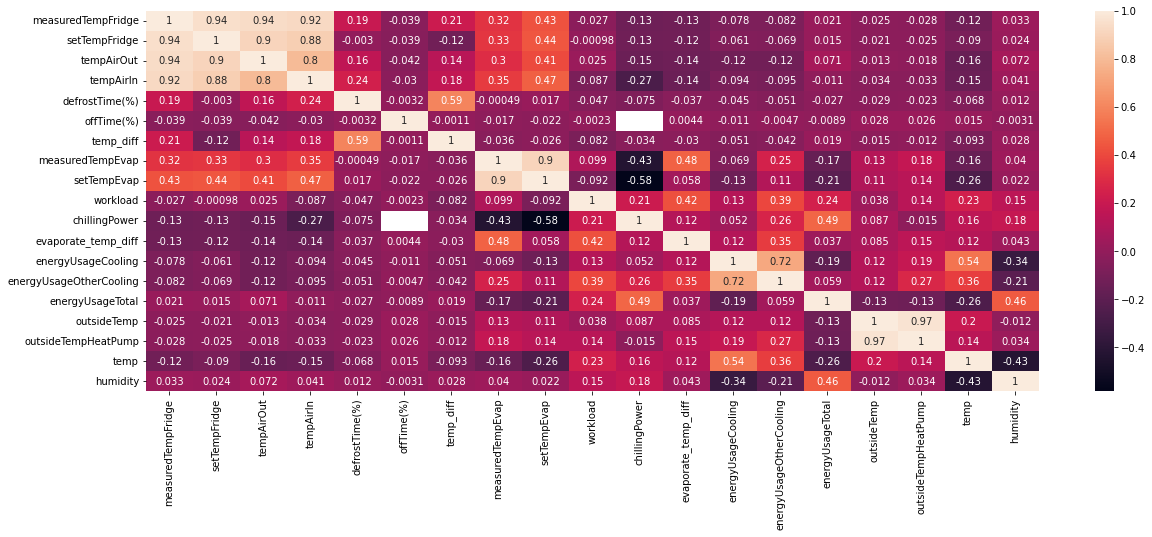

In [10]:
plt.figure(figsize=(20, 7))
# sns.heatmap(data.corr(), annot=True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));
sns.heatmap(data.corr(), annot=True);

* Outside temperature correlates extremely highly to outside temperature heat pump. Therefore both variables are likely unnecessary. I will continue the analysis with only looking at outsideTempHeatPump.
* The temperature of the fridge and the temperature of the air inlet/outlets also correlate very strongly. The temp of the air inlet/outlets have a strong correlation of 0.8. However as this attribute is very relevant to the analysis, I will continue to look at both variables.
* Energy usage for cooling, and energy usage for "other cooling" also have a strong correlation of 0.72. Both variables may be unnecessary, particularly as they may be too "general" for this analysis. 

As this correlation plot uses data from all of the supermarkets, it is possible that some correlations may be obscured by differences between the supermarkets - even so, some relations are still very evident.

### Which supermarkets can be used for the analysis?<a name="markets"></a>

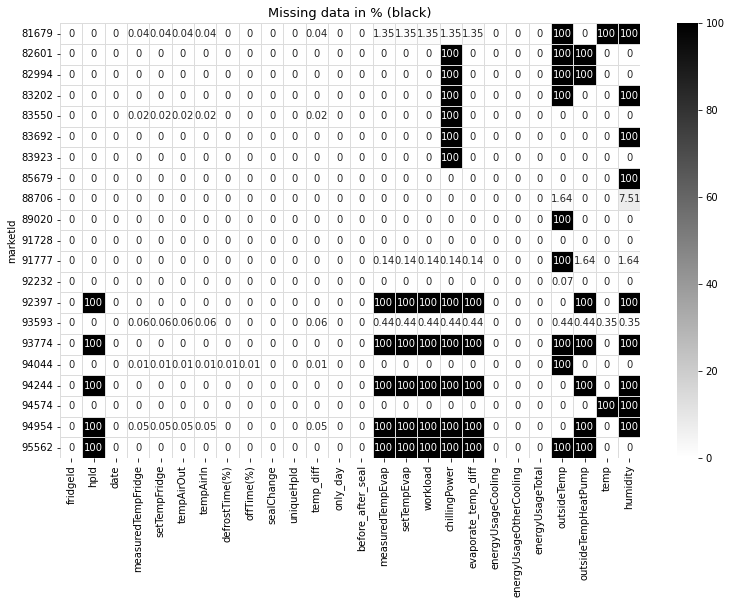

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))
ax = sns.heatmap(data.groupby("marketId", dropna=False).apply(lambda df: round(df.isna().sum()/len(df)*100, 2)).drop(["marketId"], axis=1),
                xticklabels=True, yticklabels=True, ax=ax, linecolor="gainsboro", cmap="binary", linewidths=1, annot=True, fmt="g")
ax.set_title("Missing data in % (black)", fontsize=13);

Considering only relevant variables:  
Supermarkets 89020, 91728 and 92232 are missing no data, therefore can be used for the analysis.  
Supermarkets 91777, 93593 and 94044, are missing only very little data (mostly less than 1% of the data), therefore could feasibly be used in the analysis.  
Supermarket 88706 is missing 7.5% of the data on the variable "humidity". It is questionable whether this supermarket could be used in the analysis, therefore I choose to leave it out.

Rows containing NAs cannot be processed by the algorithm. I therefore choose to use the 6 supermarkets with little missing data for the analysis.

In [12]:
good_markets_data = data_no_cat[(data_no_cat["marketId"]==89020) | (data_no_cat["marketId"]==91728) | (data_no_cat["marketId"]==92232) | (data_no_cat["marketId"]==91777) | (data_no_cat["marketId"]==93593) | (data_no_cat["marketId"]==94044)]

Heatpump group 91777.2.0 has chillingPower = 0 for almost the entire dataset. It is likely that this value is a proxy for a NaN. Therefore this heat pump group is dropped.  
Any other rows contains NAs are also dropped.

In [13]:
good_markets_data = good_markets_data[good_markets_data["uniqueHpId"]!="91777.2.0"]

In [14]:
good_markets_data = good_markets_data.reset_index(drop=True)
good_markets_data["marketId"] = good_markets_data["marketId"].astype("category")
good_markets_data["fridgeId"] = good_markets_data["fridgeId"].astype("category")
good_markets_data["hpId"] = good_markets_data["hpId"].astype("category")
good_markets_data["uniqueHpId"] = good_markets_data["uniqueHpId"].astype("category")
good_markets_data["before_after_seal"] = good_markets_data["before_after_seal"].astype("category")

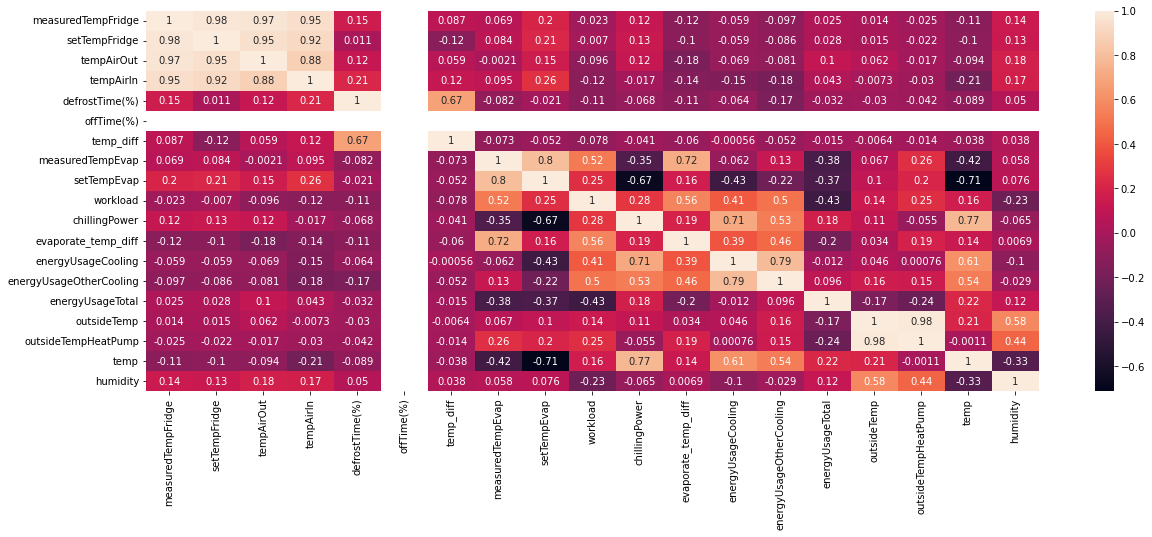

In [15]:
plt.figure(figsize=(20, 7))
sns.heatmap(good_markets_data.corr(), annot=True);

### How to model the data?<a name="domain"></a>

Due to the fact that the before/after seal attribute correlates strongly with time, trying to predict this variable (such as with logistic regression) will simply mean that the model will instead use the pattern over time inherent to attributes like humidity and outside temperature to make predictions. i.e. as all of the "before seal" observations occur in the first half of the time period, and all of the "after seal" observations occur in the second half of the time period, then if temperature linearly decreases over time, the model can simply say: if temperature > 10 degrees, predict "before", if temperature < 10 degrees, predict "after". This model would have an extremely high level of accuracy, however it is not predicting any useful, or saying anything about the door seal change!

I therefore instead **take a different approach**, based on considering the domain and mechanics of the real world problem.

**How a heat pump works**:
1. Compressing air increases the density of the air particles (same number of particles in a smaller space). Compressing air requires work/energy. This increases the speed of the air particles and thus their temperature.
2. Then we cool down the hot compressed air. This uses the outside air.
3. Then let it expand into a larger volume again. This will now be cooler than the original non-compressed air. Because the energy stays the same, but the volume gets bigger. The act of going from a cooled compressed air to an expanded air, cools it down even more.
4. Then pump cold gas into the fridge. This transfers the "cold" into the fridge. The gas will get warmed from the warmth in the fridge. Thus the cycle must continue again.

To compress the air requires energy. **What affects how much energy is required**:  
* Current temperature of inside of fridge (will change how much you need to cool it or not)
* Humidity - because it changes the heat capacity of the air inside the fridge, therefore may need more/less energy to cool it. 
    - However humidity also affects how much heat gets taken off the compressed gas - so both can have opposite effects.
* Outside temperatures, because it changes effectiveness of taking heat off the compressed gas.
* The door seal! Because a good door seal will mean the temperatures of all the different elements inside of the fridge is maintained.

Therefore my modelling approach will be to try to **predict chiller power** (representing the energy required to power the heat pump), and thus the cost effectiveness of the system.
The attributes used to predict chiller power will be attributes that are **effectors** directly changing how much energy is required for cooling (humidity). But there are also **consequences** (air stream and evaporator temperatures) - i.e. these temperatures are controlled by the heat pump, in response to variables like humidity, temperature, etc.   
*(I choose chiller power over workload, which has an extremely strong correlation to chiller power, because chiller power uses kW whereas workload is in %, thus kW can be related better to a direct energy use, costs, etc.)*

Most importantly, will be **including the door seal change as a variable, and seeing how it affects the chiller power required**, which will be dependent on/accounting for the current humidity, outside temperatures, etc.

**An idea for a model would therefore be:**  
y = chiller power  
x = humidity + outsidetemp + insidetemp + fridgetemp + door_seal_change + INTERACTIONS + POLYNOMIALS + possibly(inlet temp + evaporator temps) + fridge_set_temp + num_of_fridges_controlled_by_heat_pump + heatpumpId

The fridge's intended set temperature is included in the model, because different (types of) fridges have different set temperatures, therefore the deltas between these may be relevant.

The temperature of the fridge was stated to generally already stay within the required bounds, therefore this value is perhaps not useful to optimise. However if the door seal change could reduce the amount of energy required to run the heat pumps, then this would be a useful change for the business.  

Subsetting only the variables required for analysis, and dropping all rows contained NAs.

In [16]:
good_markets_data = good_markets_data[["fridgeId", "uniqueHpId", "date", "marketId", "measuredTempFridge", "setTempFridge", "tempAirOut",
                  "tempAirIn", "before_after_seal", "measuredTempEvap", "setTempEvap", "chillingPower", "outsideTempHeatPump", "temp","humidity"]]

In [17]:
good_markets_data = good_markets_data.dropna(axis=0, how="any")

### Aggregating the data to the "heat pump" level<a name="agg"></a>

Now given the approach of trying to predict the variable "chillingPower", the dataset must therefore be aggregated to the heat pump level.

Each fridge is associated with a heat pump group. The original "large form" dataset includes each fridge's individual data, with the chilling power measurements taken from each fridges associated heat pump (at each point in time) duplicated to each individual fridge's observation row.

This could therefore obscure the relationship between the attributes and chilling power. For example: say 5 fridges in a "heat pump group" have cold temperatures, and one fridge "F" has extremely hot temperatures. As a result of the one fridge, the cooling system will require a lot more energy to cool down the one fridge. Therefore on the observations for "F" we will rightly see the connection between hot temperatures, and high energy use by the chiller. However, for the other 5 fridges, we will see observations that suggest a connection between cold temperatures, and high energy use! The true relationship is totally hidden, due to the fact that we have proliferated the "group" energy variable to the "individual" fridges - even though this group variable only makes sense when you look at the group as whole.

I will therefore aggregate together the individual fridge data back to the level of the heatpumps. Taking the average of the individual fridge temperatures will ensure we can see how the chilling power responds to the average tempearture of the fridge group as a whole.

The deltas between average temperature and average intended temperature is acceptable to be aggregated, because of the linearity of heat flow.

There are 8 different heatpumps associated with the 6 supermarkets used for the dataset.

In [18]:
list(good_markets_data["uniqueHpId"].unique())

['89020.1.0',
 '89020.2.0',
 '91777.3.0',
 '91728.2.0',
 '92232.1.0',
 '93593.2.0',
 '94044.2.0',
 '94044.3.0']

Some of the fridges have different set temperatures. This must be included within the dataset, as the relationship between variables may be confused otherwise. (i.e. a temperature of 5.9 could represent a need for strong chilling energy for a fridge with a set point of 1.0, or no chilling required for a fridge with a set point of 6.0).

In [19]:
good_markets_data.groupby("uniqueHpId")["setTempFridge"].unique()

uniqueHpId
89020.1.0               [6.0]
89020.2.0               [1.0]
91728.2.0          [6.0, 1.0]
91777.3.0               [1.0]
92232.1.0    [6.0, 1.0, 10.0]
93593.2.0          [6.0, 1.0]
94044.2.0               [6.0]
94044.3.0               [1.0]
Name: setTempFridge, dtype: object

The number of fridges within each heat pump group will also effect how much power the heat pump requires.

In [20]:
num_fridges_in_heat_pump = good_markets_data.groupby("uniqueHpId")["fridgeId"].nunique().to_dict()
num_fridges_in_heat_pump

{'89020.1.0': 12,
 '89020.2.0': 1,
 '91728.2.0': 11,
 '91777.3.0': 1,
 '92232.1.0': 12,
 '93593.2.0': 13,
 '94044.2.0': 10,
 '94044.3.0': 1}

In [21]:
final_dataset = good_markets_data.groupby(["uniqueHpId", "date"]).agg({"marketId":lambda row: pd.Series.mode(row), 
                                                       "uniqueHpId": lambda row: pd.Series.mode(row),
                                                       "measuredTempFridge":"mean",
                                                       "setTempFridge":"mean",
                                                       "tempAirOut":"mean",
                                                       "tempAirIn":"mean",
                                                       "before_after_seal": lambda row: pd.Series.mode(row),
                                                       "measuredTempEvap":"mean",
                                                       "setTempEvap":"mean",
                                                       "chillingPower":"mean",
                                                       "outsideTempHeatPump":"mean",
                                                       "temp":"mean",
                                                       "humidity":"mean"})
final_dataset.index = final_dataset.index.droplevel()
final_dataset = final_dataset.reset_index()
final_dataset = final_dataset.dropna(axis=0, how="any")
final_dataset = final_dataset.reset_index(drop=True)
final_dataset["marketId"] = final_dataset["marketId"].astype(int).astype("category")
final_dataset["numOfFridges"] = final_dataset["uniqueHpId"].map(num_fridges_in_heat_pump)

In [22]:
final_dataset.columns = ["date", "marketId", "uniqueHpId", "avgMeasuredTempFridge", "avgSetTempFridge", "avgTempAirOut", "avgTempAirIn",
                         "before_after_seal", "avgMeasuredTempEvap", "avgSetTempEvap", "chillingPower", "outsideTempHeatPump", "marketTemp", "humidity", "numOfFridges"]

In [23]:
final_dataset = final_dataset[["date", "marketId", "uniqueHpId", "numOfFridges", "avgMeasuredTempFridge", "avgSetTempFridge", "avgTempAirOut", "avgTempAirIn", "avgMeasuredTempEvap", "avgSetTempEvap",
              "outsideTempHeatPump", "marketTemp", "humidity", "before_after_seal", "chillingPower"]]

In [24]:
final_dataset

date marketId uniqueHpId  numOfFridges  \
0     2021-12-29 00:00:00+00:00    89020  89020.1.0            12   
1     2021-12-29 01:00:00+00:00    89020  89020.1.0            12   
2     2021-12-29 02:00:00+00:00    89020  89020.1.0            12   
3     2021-12-29 03:00:00+00:00    89020  89020.1.0            12   
4     2021-12-29 04:00:00+00:00    89020  89020.1.0            12   
...                         ...      ...        ...           ...   
10683 2022-02-28 19:00:00+00:00    94044  94044.3.0             1   
10684 2022-02-28 20:00:00+00:00    94044  94044.3.0             1   
10685 2022-02-28 21:00:00+00:00    94044  94044.3.0             1   
10686 2022-02-28 22:00:00+00:00    94044  94044.3.0             1   
10687 2022-02-28 23:00:00+00:00    94044  94044.3.0             1   

       avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0                   6.229167               6.0       6.687500      5.770833   
1                   5.875000               6.0       6.395833      5.270833   
2                   6.083333               6.0       6.562500      5.625000   
3                   6.083333               6.0       6.500000      5.583333   
4                   5.979167               6.0       6.479167      5.395833   
...                      ...               ...            ...           ...   
10683               1.000000               1.0       1.500000      0.000000   
10684               1.500000               1.0       2.500000      0.250000   
10685               1.000000               1.0       2.000000     -0.500000   
10686               4.250000               1.0       4.500000      4.000000   
10687               0.500000               1.0       1.250000     -0.750000   

       avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0                    -1.50           -1.05                 3.80   14.875000   
1                    -1.65           -1.00                 4.45   14.750000   
2                    -1.90           -1.20                 5.25   14.825000   
3                    -0.60           -0.50                 5.85   14.850000   
4                    -1.00           -0.20                 5.70   14.850000   
...                    ...             ...                  ...         ...   
10683                -6.15           -5.40                 3.55   17.549999   
10684                -6.45           -5.15                 2.90   17.849998   
10685                -6.75           -5.30                 3.35   18.075001   
10686                -6.30           -5.30                 4.45   17.325001   
10687                -6.30           -5.30                 4.35   16.500000   

       humidity before_after_seal  chillingPower  
0          49.0            before          4.625  
1          49.0            before          5.500  
2          48.0            before          4.500  
3          48.0            before          5.000  
4          48.0            before          3.625  
...         ...               ...            ...  
10683      38.0             after          2.750  
10684      38.0             after          2.625  
10685      37.0             after          2.625  
10686      38.0             after          2.750  
10687      39.0             after          2.625  

[10688 rows x 15 columns]

### Investigating the dataset attributes visually<a name="visual"></a>

In [25]:
# looking only at the most interesting variables
all_vars = ["avgMeasuredTempFridge", "avgSetTempFridge", "avgTempAirOut", "avgTempAirIn", "avgMeasuredTempEvap", "avgSetTempEvap", "outsideTempHeatPump", "marketTemp", "humidity", "chillingPower"]

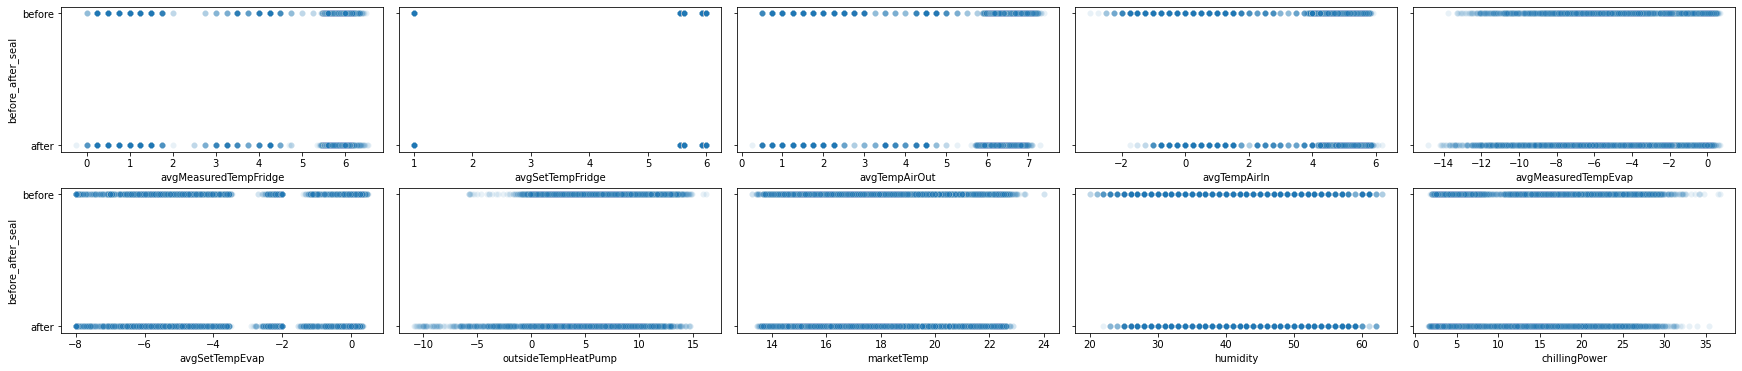

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,6), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.25)

for i in range(0, 10):
    sns.scatterplot(data=final_dataset, y="before_after_seal", x=all_vars[i], alpha=0.1, ax=axes.ravel()[i])

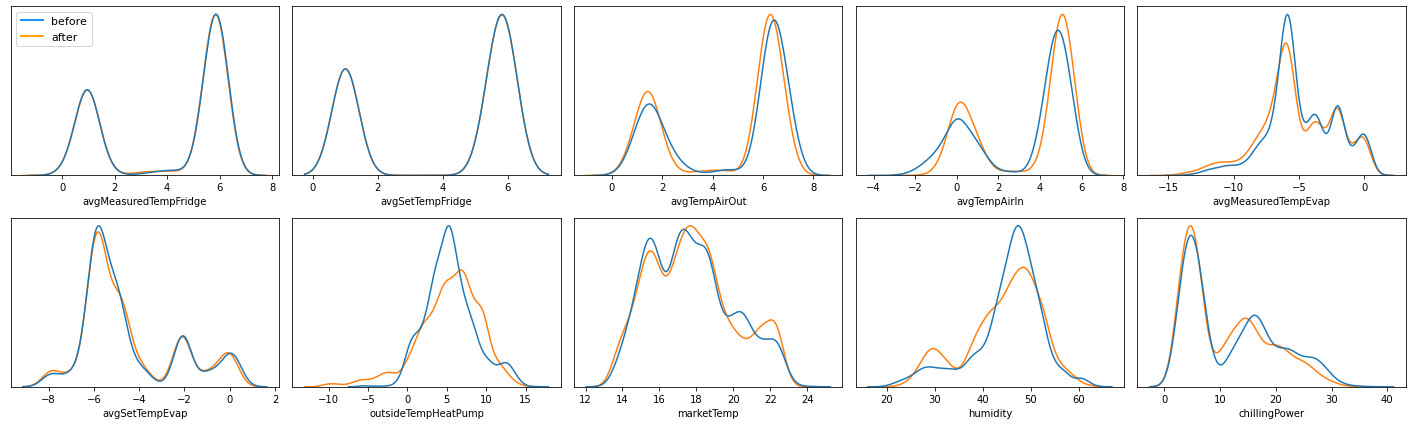

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,7))
fig.subplots_adjust(wspace=0.05, hspace=0.25)

for i in range(0, 10):
    sns.kdeplot(data=final_dataset, x=all_vars[i], hue="before_after_seal", multiple="layer", ax=axes.ravel()[i], common_norm=False, legend=False)
    axes.ravel()[i].set_yticks(())
    axes.ravel()[i].set_ylabel("")
axes.ravel()[0].legend(handles=[Line2D([], [], color='dodgerblue', lw = 2), Line2D([], [], color='orange', lw = 2)], labels=["before", "after"], fontsize=11)

Based on the data, no single variable alone seems to be a good predictor of the door seal change. Furthermore, no two variables together well separate out the before/after door seal change groups. Therefore it is likely that interaction terms are necessary: i.e. the way that one variable affects another is modified by another variable(s).

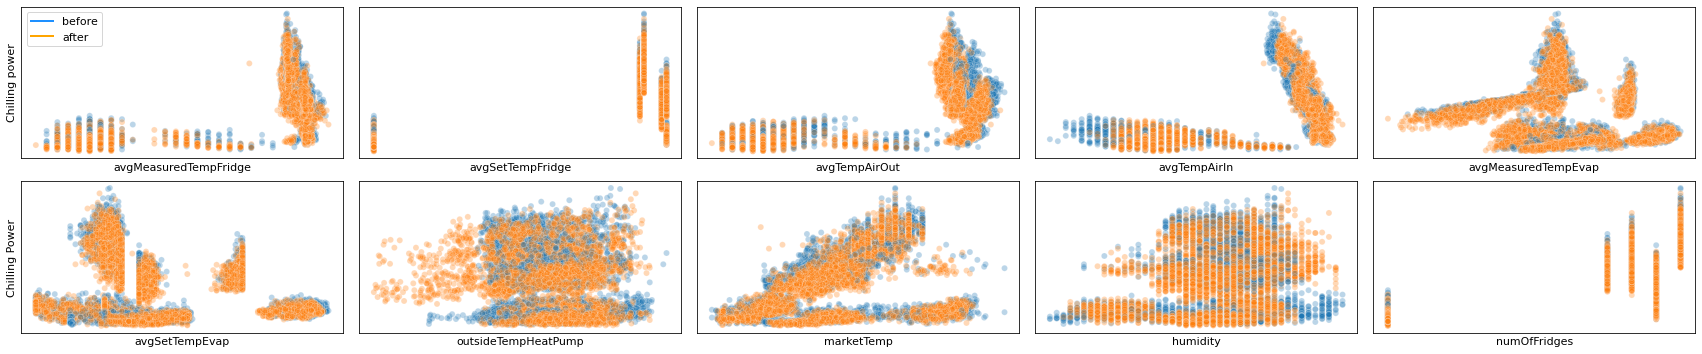

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,6))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

# plotting the scatterplot comparisons between two variables, coloured by before/after door seal group
for i in range(0, 10):
    ax = axes.ravel()[i]
    axes.ravel()[0].set_ylabel("Chilling power", fontsize=11)
    axes.ravel()[5].set_ylabel("Chilling Power", fontsize=11)
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel((all_vars[:-1]+["numOfFridges"])[i], fontsize=11)
    sns.scatterplot(data=final_dataset, y="chillingPower", hue="before_after_seal", x=(all_vars[:-1]+["numOfFridges"])[i], alpha=0.3, ax=ax, legend=False)
axes.ravel()[0].legend(handles=[Line2D([], [], color='dodgerblue', lw = 2), Line2D([], [], color='orange', lw = 2)], labels=["before", "after"], fontsize=11);

The relationship between the variables and the chilling power required is certainly not linear, and definitely modified by the presence of other variables. (As evidenced by the different "clusters" in the plots).

However, the plots also show there are no clear outliers, which is good.

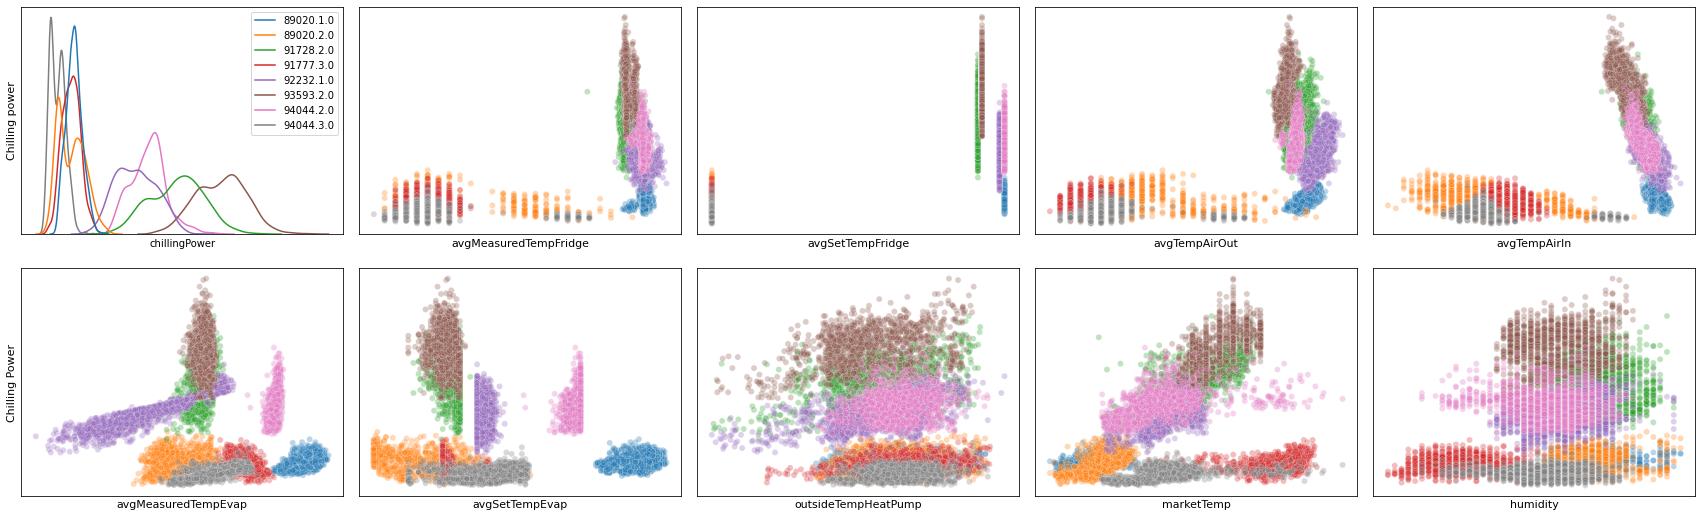

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,9))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

# plotting the histogram
sns.kdeplot(data=final_dataset, x="chillingPower", hue="uniqueHpId", multiple="layer", ax=axes.ravel()[0])
axes.ravel()[0].set_ylabel("Chilling power", fontsize=11)
axes.ravel()[5].set_ylabel("Chilling Power", fontsize=11)
axes.ravel()[0].set_xticks(()), axes.ravel()[0].set_yticks(()), axes.ravel()[0].legend_.set_title(None)

# plotting the scatterplot comparisons between two variables, coloured by before/after door seal group
for i in range(1, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i-1], fontsize=11)
    sns.scatterplot(data=final_dataset, y="chillingPower", x=all_vars[i-1], hue="uniqueHpId", alpha=0.3, ax=ax, legend=False)

We can see that the clusters correspond to different heat pump groups - each heat pump group relates the variables in a different way.

The uniqueHeatPumpId must be included in the model, to account for the way that it clearly affects the relationships between the variables.

Looking at just one heat pump, there is much more before/after separation:

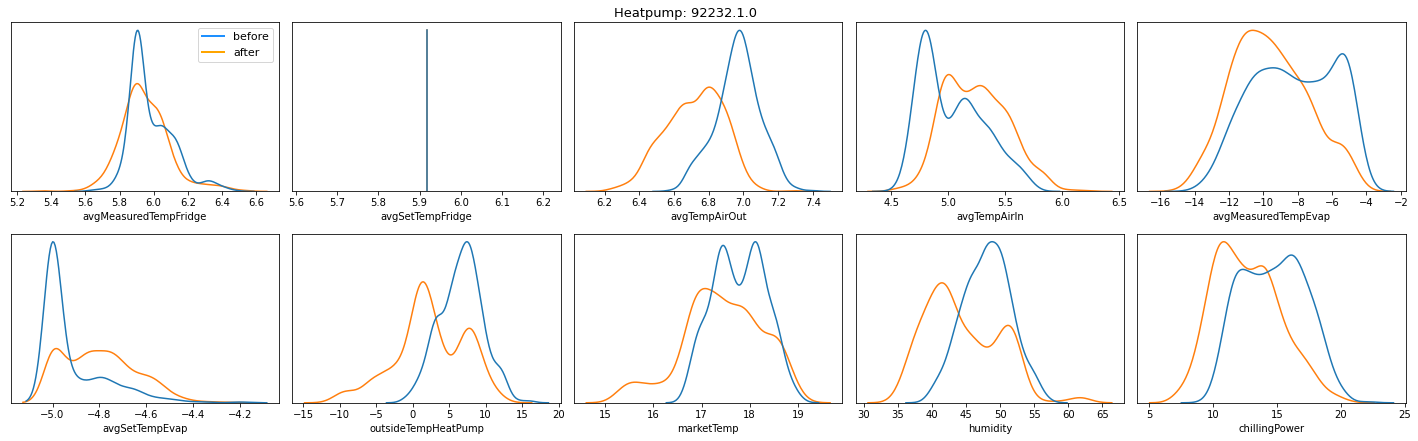

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,7))
fig.subplots_adjust(wspace=0.05, hspace=0.25)
fig.suptitle("Heatpump: 92232.1.0", fontsize=13, y=0.91);

for i in range(0, 10):
    sns.kdeplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], x=all_vars[i], hue="before_after_seal", multiple="layer", ax=axes.ravel()[i], common_norm=False, legend=False)
    axes.ravel()[i].set_yticks(())
    axes.ravel()[i].set_ylabel("")
axes.ravel()[0].legend(handles=[Line2D([], [], color='dodgerblue', lw = 2), Line2D([], [], color='orange', lw = 2)], labels=["before", "after"], fontsize=11);

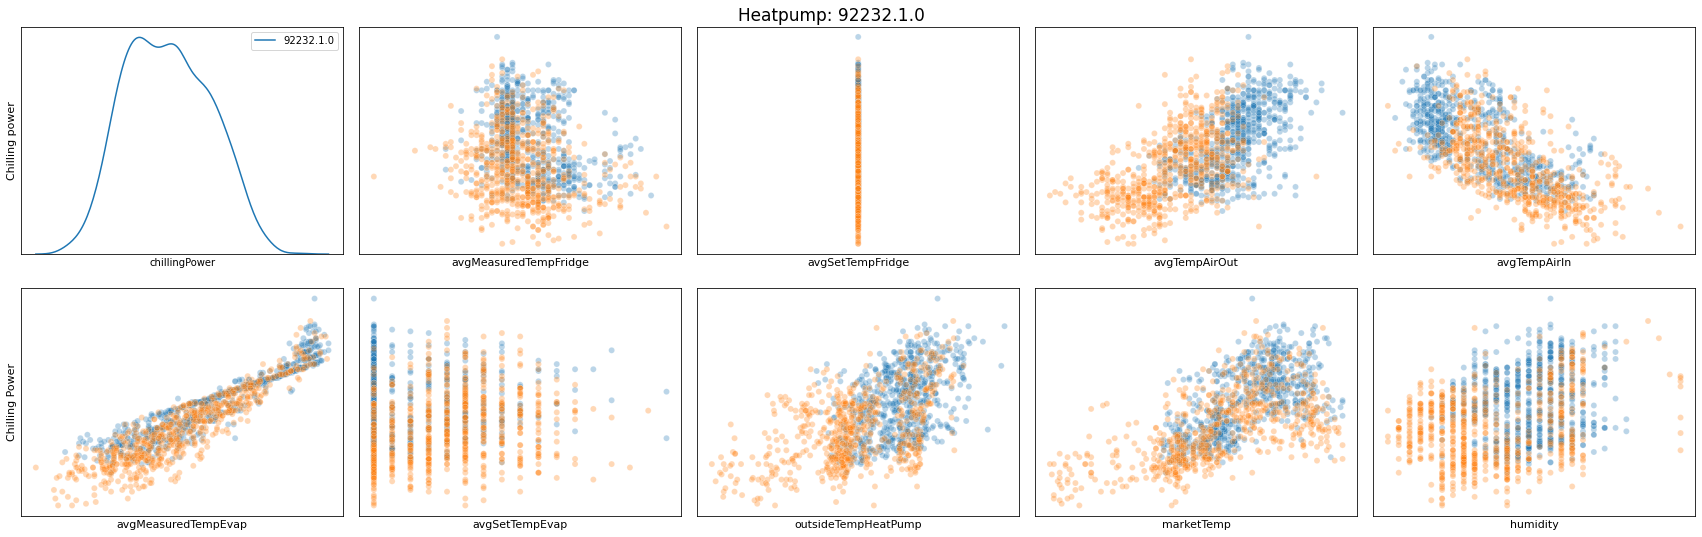

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,9))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
fig.suptitle("Heatpump: 92232.1.0", fontsize=17, y=0.91);

# plotting the histogram
sns.kdeplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], x="chillingPower", hue="uniqueHpId", multiple="layer", ax=axes.ravel()[0])
axes.ravel()[0].set_ylabel("Chilling power", fontsize=11)
axes.ravel()[5].set_ylabel("Chilling Power", fontsize=11)
axes.ravel()[0].set_xticks(()), axes.ravel()[0].set_yticks(()), axes.ravel()[0].legend_.set_title(None)

# plotting the scatterplot comparisons between two variables, coloured by before/after door seal group
for i in range(1, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i-1], fontsize=11)
    sns.scatterplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], y="chillingPower", x=all_vars[i-1], hue="before_after_seal", alpha=0.3, ax=ax, legend=False)

### How do the different variables change over time?<a name="time"></a>

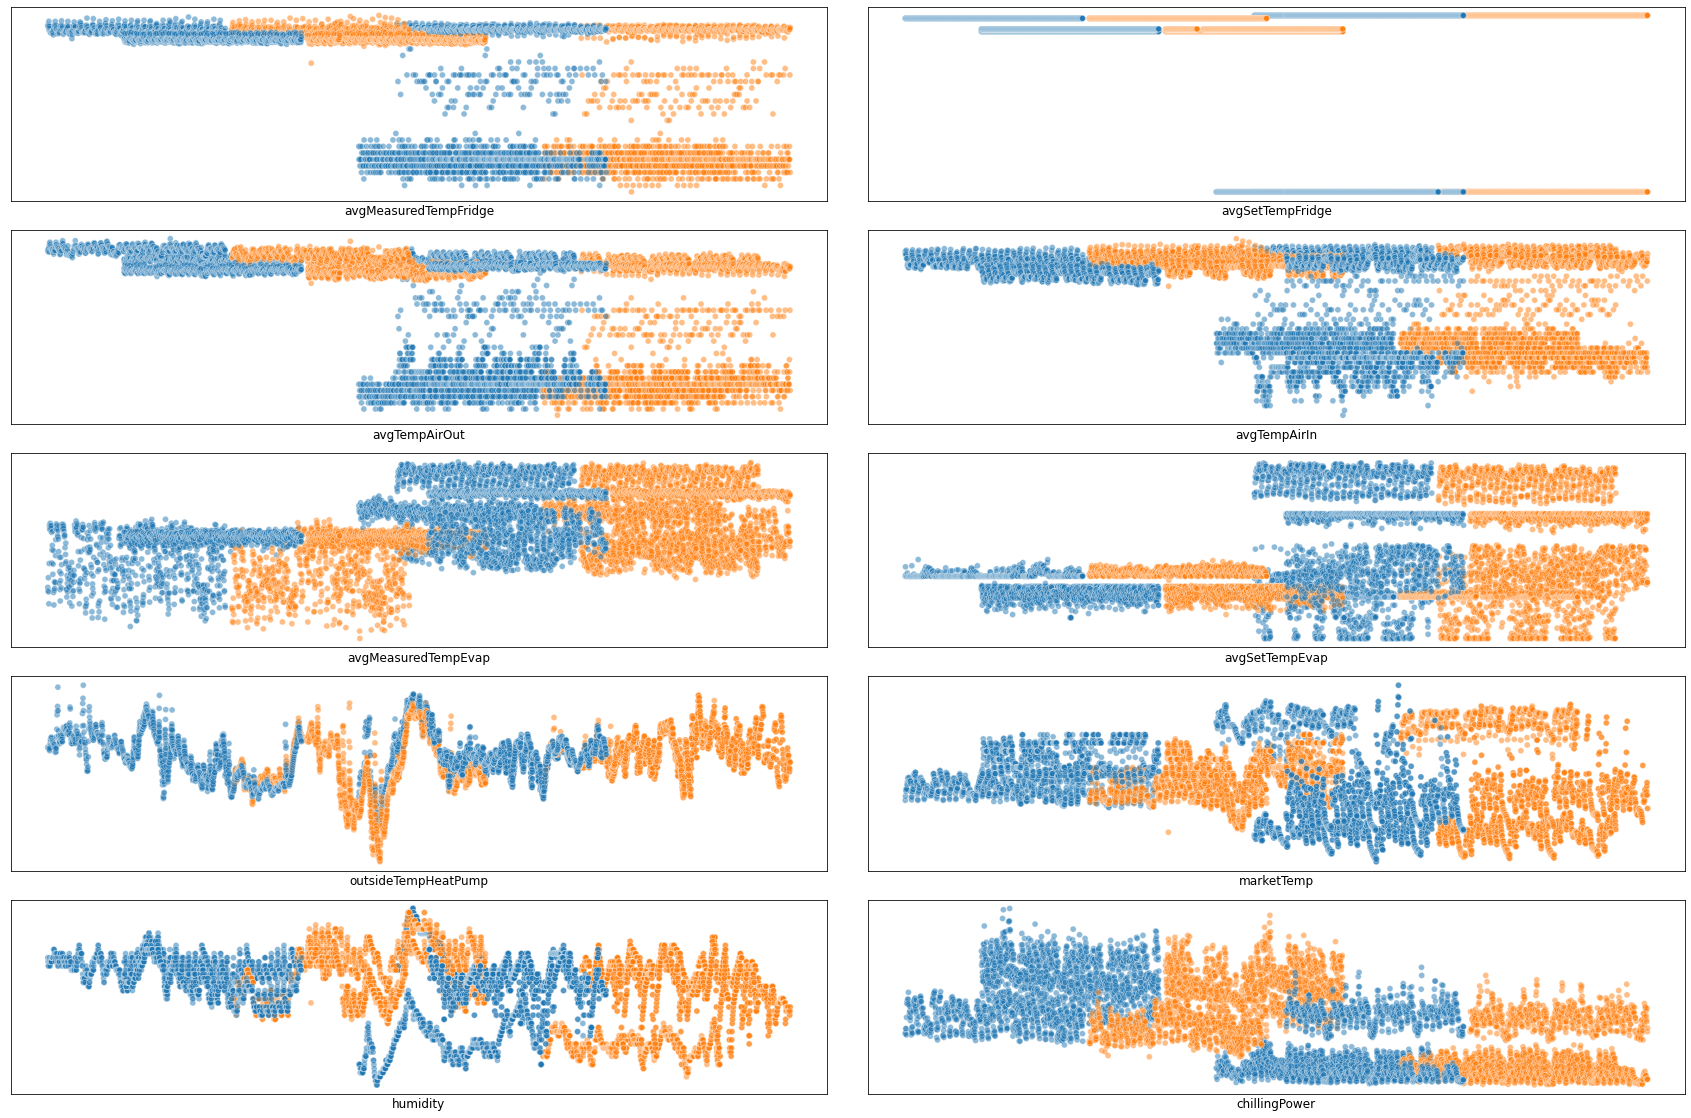

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30,20))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i in range(0, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i], fontsize=12)
    sns.scatterplot(data=final_dataset, y=all_vars[i], x="date", hue="before_after_seal", alpha=0.5, ax=ax, legend=False)

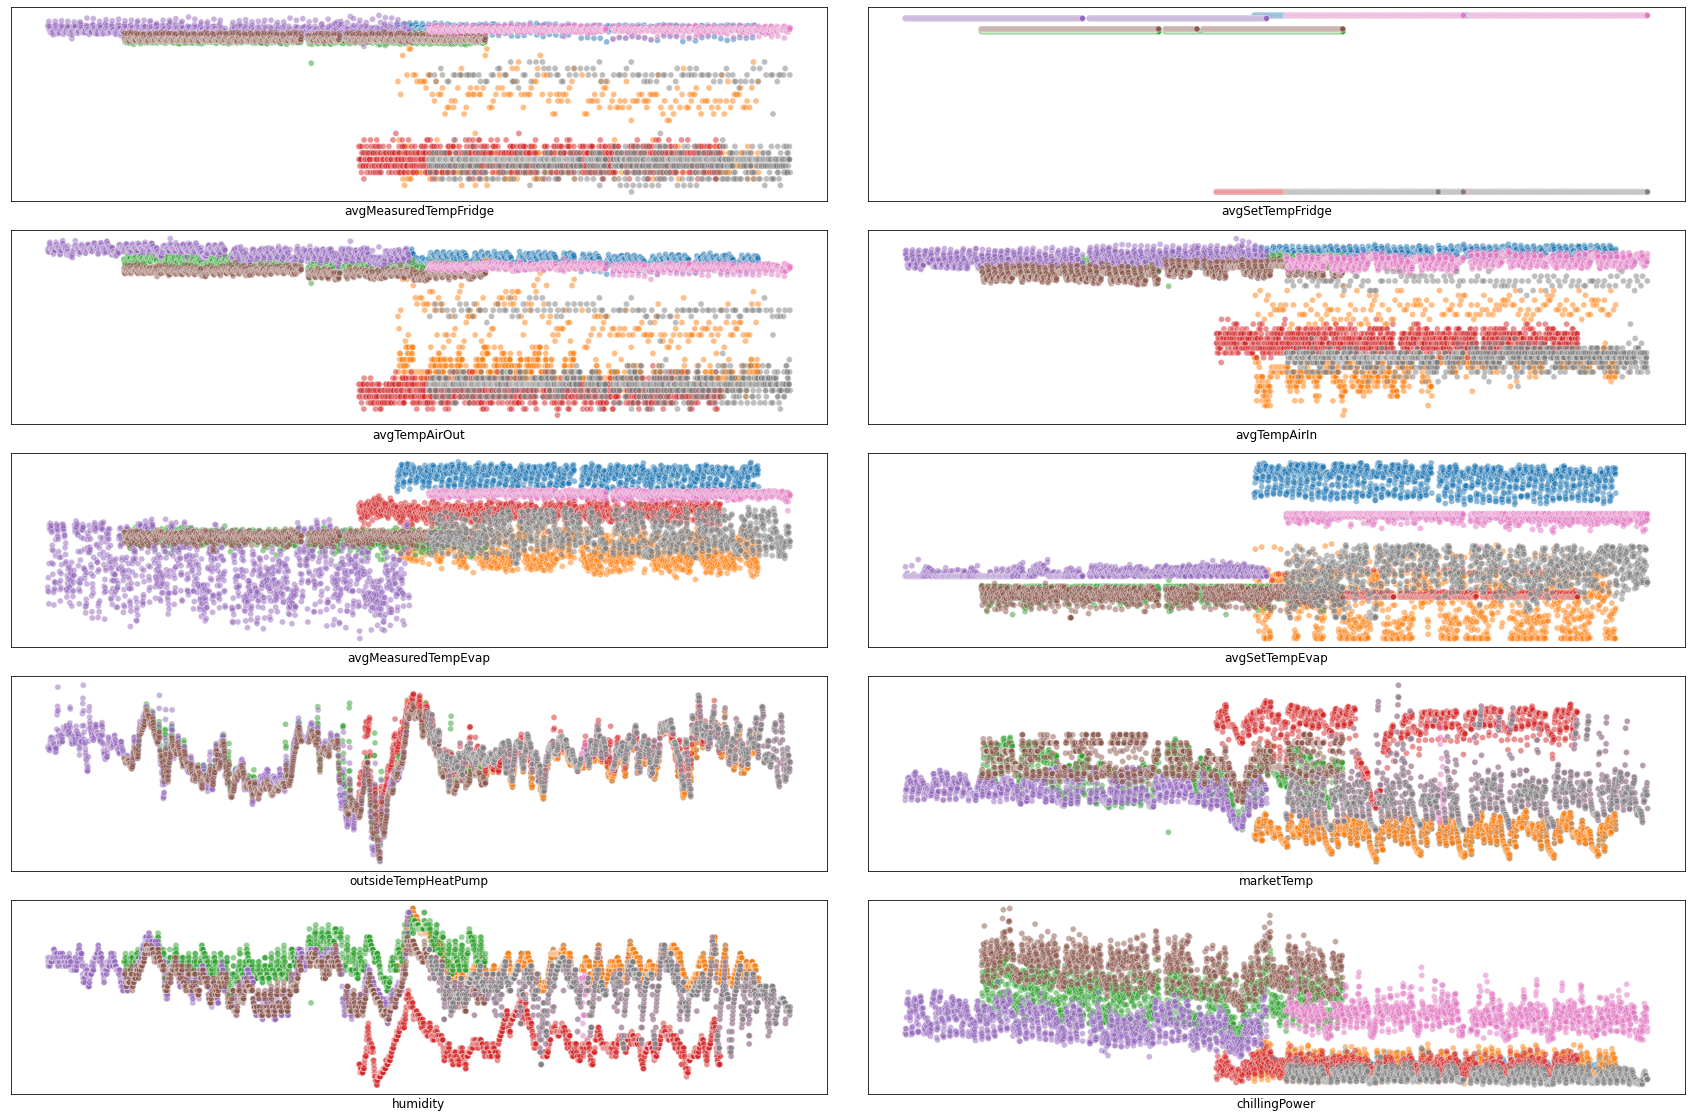

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30,20))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i in range(0, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i], fontsize=12)
    sns.scatterplot(data=final_dataset, y=all_vars[i], x="date", hue="uniqueHpId", alpha=0.5, ax=ax, legend=False)

([<matplotlib.axis.XTick at 0x7cb3c6b032e0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

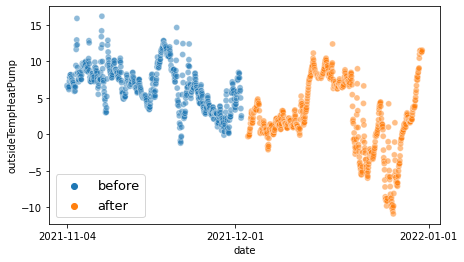

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
sns.scatterplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], y="outsideTempHeatPump", x="date", hue="before_after_seal", alpha=0.5, ax=ax)
plt.legend(loc=3, fontsize=13)
plt.xticks(["2021-11-04", "2021-12-01", "2022-01-01"])

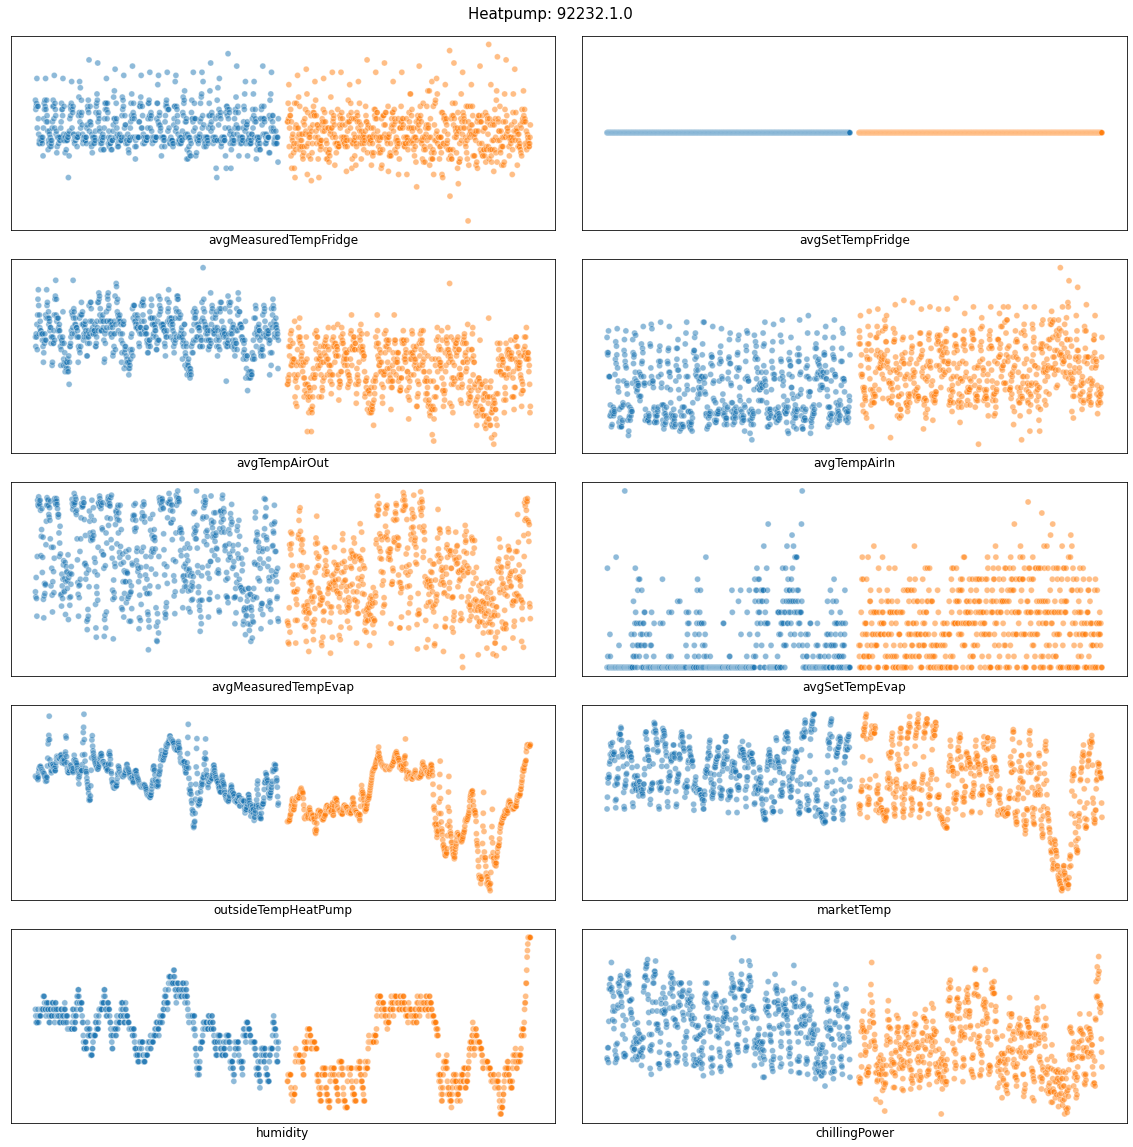

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
fig.suptitle("Heatpump: 92232.1.0", fontsize=15, y=0.9);

for i in range(0, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i], fontsize=12)
    sns.scatterplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], y=all_vars[i], x="date", hue="before_after_seal", alpha=0.5, ax=ax, legend=False)

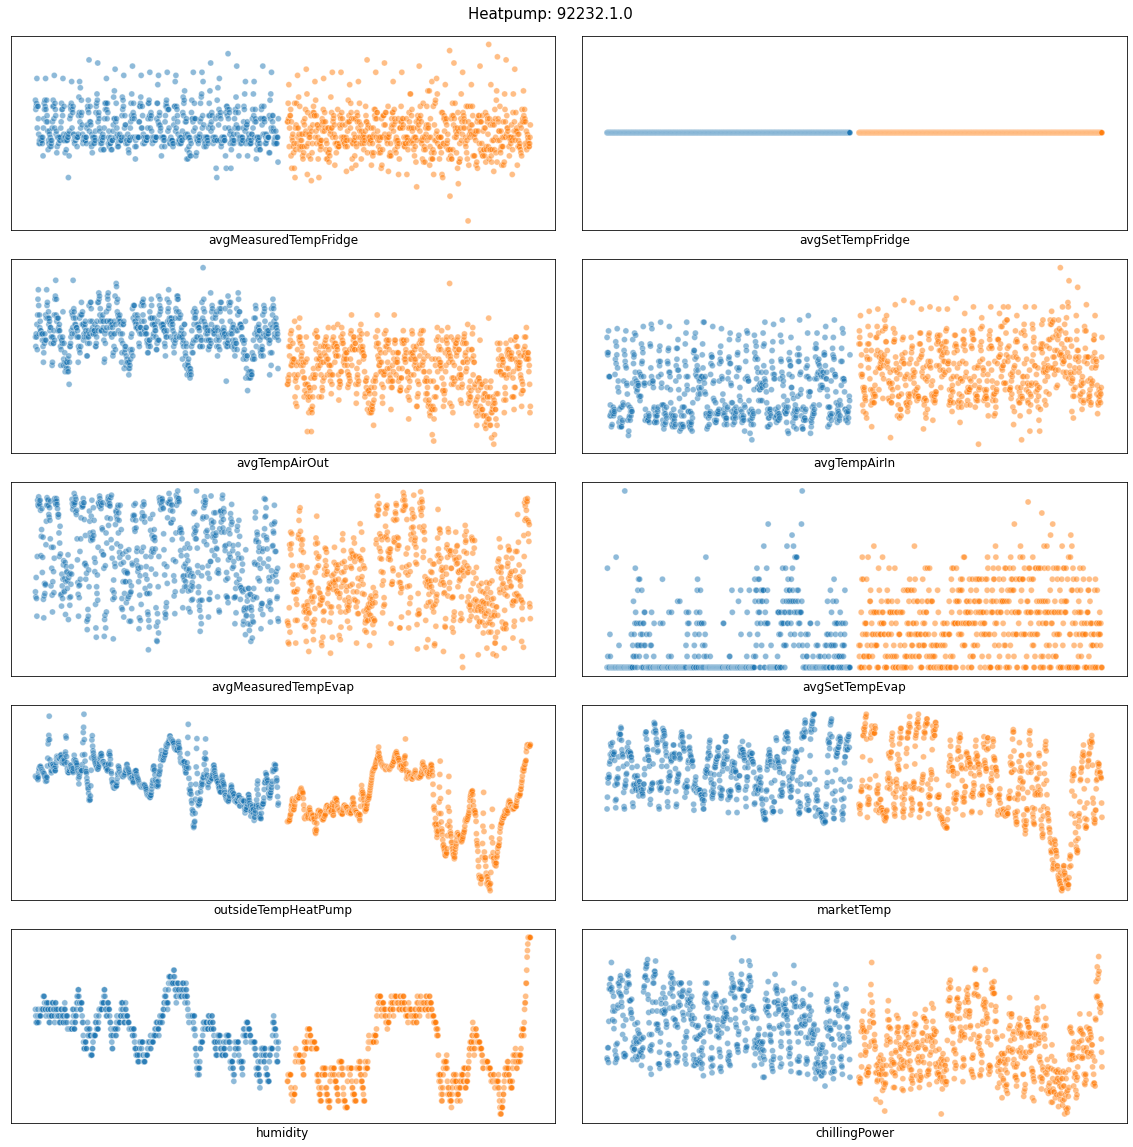

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
fig.subplots_adjust(wspace=0.05, hspace=0.15)
fig.suptitle("Heatpump: 92232.1.0", fontsize=15, y=0.9);

for i in range(0, 10):
    ax = axes.ravel()[i]
    ax.set_xticks(()), ax.set_yticks(()), ax.set_xlabel(all_vars[i], fontsize=12)
    sns.scatterplot(data=final_dataset[final_dataset["uniqueHpId"]=="92232.1.0"], y=all_vars[i], x="date", hue="before_after_seal", alpha=0.5, ax=ax, legend=False)

Outside temperatures and humidity seem to be affected by the passing of time, and follow a very similar pattern.  
The other variables seem to be less affected.

# Preprocessing data for modelling<a name="pre"></a>

## Aggregating the data to smooth it<a name="agg2"></a>

Each observation represents the values of each variable for an entire hour, however the measurement readings were taken only at a single point in time, therefore it is possible that the measurement is not truly representative. For example, if a customer happened to have the fridge door open at the exact time the measurement was taken. 

Therefore I aggregate some of the data together, in order to "smooth" out any possible outlier values. I aggregate together 3 hours (observations) into one single averaged observation. 

However the disadvantage of this approach, is that some information will be lost, and any extreme outliers will "corrupt" the non-outlier data that they are aggregated with. Therefore I will retain both datasets for future modelling.

In [37]:
print("Number of unique dates for heatpump \"89020.1.0\" in original data:", len(final_dataset[final_dataset["uniqueHpId"]=="89020.1.0"]["date"].unique()), 
      "\nWill be the reduced number:", len(final_dataset[final_dataset["uniqueHpId"]=="89020.1.0"]["date"].unique())/3)

Number of unique dates for heatpump "89020.1.0" in original data: 1344 
Will be the reduced number: 448.0


In [38]:
# dividing the dataset into two parts: before and after the door seal was changed, to ensure that I don't aggregate together values that occurred before and after the door seal change.
before_data = final_dataset[final_dataset["before_after_seal"]=="before"].reset_index(drop=True)
after_data = final_dataset[final_dataset["before_after_seal"]=="after"].reset_index(drop=True)

In [39]:
agg_data_list = []
for dataset in [before_data, after_data]:
    agg_data_list.append(dataset.groupby("uniqueHpId").resample("3H", on="date").agg({"marketId":lambda row: pd.Series.mode(row), 
                                                                                     "uniqueHpId": lambda row: pd.Series.mode(row),
                                                                                     "numOfFridges":"mean",
                                                                                     "avgMeasuredTempFridge":"mean",
                                                                                     "avgSetTempFridge":"mean",
                                                                                     "avgTempAirOut":"mean",
                                                                                     "avgTempAirIn":"mean",
                                                                                      "avgMeasuredTempEvap":"mean",
                                                                                      "avgSetTempEvap":"mean",
                                                                                      "outsideTempHeatPump":"mean",
                                                                                      "marketTemp":"mean",
                                                                                      "humidity":"mean",
                                                                                      "before_after_seal": lambda row: pd.Series.mode(row),
                                                                                      "chillingPower":"mean"}))

In [40]:
before_data_agg = agg_data_list[0]
after_data_agg = agg_data_list[1]

before_data_agg.index = before_data_agg.index.droplevel()
before_data_agg = before_data_agg.reset_index()

after_data_agg.index = after_data_agg .index.droplevel()
after_data_agg  = after_data_agg .reset_index()

In [41]:
data_agg = pd.concat([before_data_agg, after_data_agg])
data_agg = data_agg.dropna(axis=0, how="any")

In [42]:
print("Number of unique dates for heatpump \"89020.1.0\" in original data:", len(final_dataset[final_dataset["uniqueHpId"]=="89020.1.0"]["date"].unique()), 
      "\nNumber of unique dates for heatpump \"89020.1.0\" in aggregated data:", len(data_agg[data_agg["uniqueHpId"]=="89020.1.0"]["date"].unique()))

Number of unique dates for heatpump "89020.1.0" in original data: 1344 
Number of unique dates for heatpump "89020.1.0" in aggregated data: 448


In [43]:
data_agg.head()

date marketId uniqueHpId  numOfFridges  \
0 2021-12-29 00:00:00+00:00    89020  89020.1.0          12.0   
1 2021-12-29 03:00:00+00:00    89020  89020.1.0          12.0   
2 2021-12-29 06:00:00+00:00    89020  89020.1.0          12.0   
3 2021-12-29 09:00:00+00:00    89020  89020.1.0          12.0   
4 2021-12-29 12:00:00+00:00    89020  89020.1.0          12.0   

   avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0               6.062500               6.0       6.548611      5.555556   
1               6.020833               6.0       6.506944      5.500000   
2               6.125000               6.0       6.840278      5.444444   
3               5.944444               6.0       6.770833      5.118056   
4               6.000000               6.0       6.743056      5.229167   

   avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0            -1.683333       -1.083333             4.500000   14.816667   
1            -0.616667       -0.316667             5.900000   14.850000   
2            -0.600000       -0.383333             6.433333   14.908333   
3            -0.200000       -0.033333             7.200000   15.508333   
4            -0.116667       -0.033333             8.100001   15.608333   

    humidity before_after_seal  chillingPower  
0  48.666667            before       4.875000  
1  48.333333            before       5.333333  
2  50.333333            before       6.083333  
3  51.333333            before       6.833333  
4  53.000000            before       7.833333

## One-hot encoding the categorical variables and splitting up the heat pumps<a name="onehot"></a>

Some implementations of algorithms in Python cannot handle the different levels in categorical variables, therefore they must be one-hot encoded.

The before/after door seal variable can simply be replaced by a binary 0/1 indicator.

In [44]:
final_dataset["before_after_seal"] = final_dataset["before_after_seal"].map({"before":0, "after":1})
data_agg["before_after_seal"] = data_agg["before_after_seal"].map({"before":0, "after":1})

In [45]:
final_dataset

date marketId uniqueHpId  numOfFridges  \
0     2021-12-29 00:00:00+00:00    89020  89020.1.0            12   
1     2021-12-29 01:00:00+00:00    89020  89020.1.0            12   
2     2021-12-29 02:00:00+00:00    89020  89020.1.0            12   
3     2021-12-29 03:00:00+00:00    89020  89020.1.0            12   
4     2021-12-29 04:00:00+00:00    89020  89020.1.0            12   
...                         ...      ...        ...           ...   
10683 2022-02-28 19:00:00+00:00    94044  94044.3.0             1   
10684 2022-02-28 20:00:00+00:00    94044  94044.3.0             1   
10685 2022-02-28 21:00:00+00:00    94044  94044.3.0             1   
10686 2022-02-28 22:00:00+00:00    94044  94044.3.0             1   
10687 2022-02-28 23:00:00+00:00    94044  94044.3.0             1   

       avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0                   6.229167               6.0       6.687500      5.770833   
1                   5.875000               6.0       6.395833      5.270833   
2                   6.083333               6.0       6.562500      5.625000   
3                   6.083333               6.0       6.500000      5.583333   
4                   5.979167               6.0       6.479167      5.395833   
...                      ...               ...            ...           ...   
10683               1.000000               1.0       1.500000      0.000000   
10684               1.500000               1.0       2.500000      0.250000   
10685               1.000000               1.0       2.000000     -0.500000   
10686               4.250000               1.0       4.500000      4.000000   
10687               0.500000               1.0       1.250000     -0.750000   

       avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0                    -1.50           -1.05                 3.80   14.875000   
1                    -1.65           -1.00                 4.45   14.750000   
2                    -1.90           -1.20                 5.25   14.825000   
3                    -0.60           -0.50                 5.85   14.850000   
4                    -1.00           -0.20                 5.70   14.850000   
...                    ...             ...                  ...         ...   
10683                -6.15           -5.40                 3.55   17.549999   
10684                -6.45           -5.15                 2.90   17.849998   
10685                -6.75           -5.30                 3.35   18.075001   
10686                -6.30           -5.30                 4.45   17.325001   
10687                -6.30           -5.30                 4.35   16.500000   

       humidity  before_after_seal  chillingPower  
0          49.0                  0          4.625  
1          49.0                  0          5.500  
2          48.0                  0          4.500  
3          48.0                  0          5.000  
4          48.0                  0          3.625  
...         ...                ...            ...  
10683      38.0                  1          2.750  
10684      38.0                  1          2.625  
10685      37.0                  1          2.625  
10686      38.0                  1          2.750  
10687      39.0                  1          2.625  

[10688 rows x 15 columns]

Due to the very significant differences between the heat pumps, we may want to use the heat pump id as a categorical variable in the modelling. An alternative approach is to model each of the heat pumps separately.

In [46]:
all_heat_pumps = {hp:final_dataset[final_dataset["uniqueHpId"]==hp] for hp in list(final_dataset["uniqueHpId"].unique())}

In [47]:
final_dataset = pd.merge(final_dataset, pd.DataFrame(OneHotEncoder().fit_transform(final_dataset[["uniqueHpId"]]).toarray(), columns=["heatPump_" + val for val in list(OneHotEncoder().fit(final_dataset[["uniqueHpId"]]).categories_[0])]),
                left_index=True, right_index=True)
data_agg = pd.merge(data_agg, pd.DataFrame(OneHotEncoder().fit_transform(data_agg[["uniqueHpId"]]).toarray(), columns=["heatPump_" + val for val in list(OneHotEncoder().fit(data_agg[["uniqueHpId"]]).categories_[0])]),
                left_index=True, right_index=True)

In [48]:
final_dataset

date marketId uniqueHpId  numOfFridges  \
0     2021-12-29 00:00:00+00:00    89020  89020.1.0            12   
1     2021-12-29 01:00:00+00:00    89020  89020.1.0            12   
2     2021-12-29 02:00:00+00:00    89020  89020.1.0            12   
3     2021-12-29 03:00:00+00:00    89020  89020.1.0            12   
4     2021-12-29 04:00:00+00:00    89020  89020.1.0            12   
...                         ...      ...        ...           ...   
10683 2022-02-28 19:00:00+00:00    94044  94044.3.0             1   
10684 2022-02-28 20:00:00+00:00    94044  94044.3.0             1   
10685 2022-02-28 21:00:00+00:00    94044  94044.3.0             1   
10686 2022-02-28 22:00:00+00:00    94044  94044.3.0             1   
10687 2022-02-28 23:00:00+00:00    94044  94044.3.0             1   

       avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0                   6.229167               6.0       6.687500      5.770833   
1                   5.875000               6.0       6.395833      5.270833   
2                   6.083333               6.0       6.562500      5.625000   
3                   6.083333               6.0       6.500000      5.583333   
4                   5.979167               6.0       6.479167      5.395833   
...                      ...               ...            ...           ...   
10683               1.000000               1.0       1.500000      0.000000   
10684               1.500000               1.0       2.500000      0.250000   
10685               1.000000               1.0       2.000000     -0.500000   
10686               4.250000               1.0       4.500000      4.000000   
10687               0.500000               1.0       1.250000     -0.750000   

       avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0                    -1.50           -1.05                 3.80   14.875000   
1                    -1.65           -1.00                 4.45   14.750000   
2                    -1.90           -1.20                 5.25   14.825000   
3                    -0.60           -0.50                 5.85   14.850000   
4                    -1.00           -0.20                 5.70   14.850000   
...                    ...             ...                  ...         ...   
10683                -6.15           -5.40                 3.55   17.549999   
10684                -6.45           -5.15                 2.90   17.849998   
10685                -6.75           -5.30                 3.35   18.075001   
10686                -6.30           -5.30                 4.45   17.325001   
10687                -6.30           -5.30                 4.35   16.500000   

       humidity  before_after_seal  chillingPower  heatPump_89020.1.0  \
0          49.0                  0          4.625                 1.0   
1          49.0                  0          5.500                 1.0   
2          48.0                  0          4.500                 1.0   
3          48.0                  0          5.000                 1.0   
4          48.0                  0          3.625                 1.0   
...         ...                ...            ...                 ...   
10683      38.0                  1          2.750                 0.0   
10684      38.0                  1          2.625                 0.0   
10685      37.0                  1          2.625                 0.0   
10686      38.0                  1          2.750                 0.0   
10687      39.0                  1          2.625                 0.0   

       heatPump_89020.2.0  heatPump_91728.2.0  heatPump_91777.3.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...      

## Normalising the data<a name="norm"></a>

For attribute values to be properly processed by an algorithm, normalisation of the data is often required.

However, the data will need to be "de-normalised" in order to interpret the predictions later.

In [49]:
vars_to_scale = ["numOfFridges", "avgMeasuredTempFridge", "avgSetTempFridge", "avgTempAirOut",
       'avgTempAirIn', 'avgMeasuredTempEvap', 'avgSetTempEvap', 'outsideTempHeatPump', 'marketTemp', 'humidity', "chillingPower"]

In [50]:
final_dataset_norm = pd.merge(final_dataset[list(set(final_dataset.columns) - set(vars_to_scale))], 
         pd.DataFrame(StandardScaler().fit_transform(final_dataset[vars_to_scale]), columns=vars_to_scale), 
         left_index=True, right_index=True)
final_dataset_norm = final_dataset_norm[list(final_dataset.columns)]

In [51]:
data_agg_norm = pd.merge(data_agg[list(set(data_agg.columns) - set(vars_to_scale))], 
         pd.DataFrame(StandardScaler().fit_transform(data_agg[vars_to_scale]), columns=vars_to_scale), 
         left_index=True, right_index=True)
data_agg_norm = data_agg_norm[list(data_agg.columns)]

In [52]:
all_heat_pumps_norm = {}
for key in list(all_heat_pumps.keys()):
    hp = all_heat_pumps[key].reset_index(drop=True)
    all_heat_pumps_norm[key] = pd.merge(hp[list(set(hp.columns) - set(vars_to_scale))], 
         pd.DataFrame(StandardScaler().fit_transform(hp[vars_to_scale]), columns=vars_to_scale), 
         left_index=True, right_index=True)
    all_heat_pumps_norm[key] = all_heat_pumps_norm[key][list(all_heat_pumps[key].columns)]

In [53]:
final_dataset_norm

date marketId uniqueHpId  numOfFridges  \
0     2021-12-29 00:00:00+00:00    89020  89020.1.0      0.840431   
1     2021-12-29 01:00:00+00:00    89020  89020.1.0      0.840431   
2     2021-12-29 02:00:00+00:00    89020  89020.1.0      0.840431   
3     2021-12-29 03:00:00+00:00    89020  89020.1.0      0.840431   
4     2021-12-29 04:00:00+00:00    89020  89020.1.0      0.840431   
...                         ...      ...        ...           ...   
10683 2022-02-28 19:00:00+00:00    94044  94044.3.0     -1.279908   
10684 2022-02-28 20:00:00+00:00    94044  94044.3.0     -1.279908   
10685 2022-02-28 21:00:00+00:00    94044  94044.3.0     -1.279908   
10686 2022-02-28 22:00:00+00:00    94044  94044.3.0     -1.279908   
10687 2022-02-28 23:00:00+00:00    94044  94044.3.0     -1.279908   

       avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0                   0.917171          0.848862       0.868616      1.071340   
1                   0.765029          0.848862       0.744149      0.858116   
2                   0.854524          0.848862       0.815273      1.009150   
3                   0.854524          0.848862       0.788602      0.991381   
4                   0.809776          0.848862       0.779711      0.911422   
...                      ...               ...            ...           ...   
10683              -1.329164         -1.292793      -1.345111     -1.389622   
10684              -1.114375         -1.292793      -0.918368     -1.283009   
10685              -1.329164         -1.292793      -1.131740     -1.602846   
10686               0.066964         -1.292793      -0.064883      0.316171   
10687              -1.543953         -1.292793      -1.451796     -1.709458   

       avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0                 1.245770        1.634048            -0.433400   -1.256415   
1                 1.192042        1.657843            -0.253418   -1.311368   
2                 1.102495        1.562661            -0.031901   -1.278396   
3                 1.568138        1.895800             0.134237   -1.267406   
4                 1.424863        2.038573             0.092702   -1.267406   
...                    ...             ...                  ...         ...   
10683            -0.419801       -0.436171            -0.502624   -0.080423   
10684            -0.527257       -0.317193            -0.682606    0.051463   
10685            -0.634713       -0.388580            -0.558003    0.150379   
10686            -0.473529       -0.388580            -0.253418   -0.179338   
10687            -0.473529       -0.388580            -0.281107   -0.542027   

       humidity  before_after_seal  chillingPower  heatPump_89020.1.0  \
0      0.553500                  0      -0.894193                 1.0   
1      0.553500                  0      -0.781400                 1.0   
2      0.420995                  0      -0.910306                 1.0   
3      0.420995                  0      -0.845853                 1.0   
4      0.420995                  0      -1.023099                 1.0   
...         ...                ...            ...                 ...   
10683 -0.904052                  1      -1.135891                 0.0   
10684 -0.904052                  1      -1.152004                 0.0   
10685 -1.036557                  1      -1.152004                 0.0   
10686 -0.904052                  1      -1.135891                 0.0   
10687 -0.771548                  1      -1.152004                 0.0   

       heatPump_89020.2.0  heatPump_91728.2.0  heatPump_91777.3.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...      

In [54]:
all_heat_pumps_norm["89020.1.0"]

date marketId uniqueHpId  numOfFridges  \
0    2021-12-29 00:00:00+00:00    89020  89020.1.0           0.0   
1    2021-12-29 01:00:00+00:00    89020  89020.1.0           0.0   
2    2021-12-29 02:00:00+00:00    89020  89020.1.0           0.0   
3    2021-12-29 03:00:00+00:00    89020  89020.1.0           0.0   
4    2021-12-29 04:00:00+00:00    89020  89020.1.0           0.0   
...                        ...      ...        ...           ...   
1339 2022-02-23 19:00:00+00:00    89020  89020.1.0           0.0   
1340 2022-02-23 20:00:00+00:00    89020  89020.1.0           0.0   
1341 2022-02-23 21:00:00+00:00    89020  89020.1.0           0.0   
1342 2022-02-23 22:00:00+00:00    89020  89020.1.0           0.0   
1343 2022-02-23 23:00:00+00:00    89020  89020.1.0           0.0   

      avgMeasuredTempFridge  avgSetTempFridge  avgTempAirOut  avgTempAirIn  \
0                  2.502002               0.0       0.837989      1.556108   
1                 -1.706003               0.0      -0.869201     -1.050009   
2                  0.769294               0.0       0.106336      0.795991   
3                  0.769294               0.0      -0.259490      0.578814   
4                 -0.468354               0.0      -0.381432     -0.398480   
...                     ...               ...            ...           ...   
1339              -0.220824               0.0       0.350221     -0.615657   
1340              -0.220824               0.0       0.350221     -0.507068   
1341              -0.220824               0.0       0.472163     -0.832833   
1342               0.769294               0.0      -0.015606      0.578814   
1343               0.769294               0.0      -0.747259      1.013167   

      avgMeasuredTempEvap  avgSetTempEvap  outsideTempHeatPump  marketTemp  \
0               -1.650975       -1.520192            -0.682023   -0.252466   
1               -1.886803       -1.420381            -0.461555   -0.436636   
2               -2.279851       -1.819626            -0.190209   -0.326135   
3               -0.236004       -0.422267             0.013300   -0.289300   
4               -0.864880        0.176601            -0.037578   -0.289300   
...                   ...             ...                  ...         ...   
1339             0.314262        0.875280             0.386400    1.662900   
1340             1.257576        0.575846             0.301604    1.405063   
1341             0.078434        0.975092             0.216809    0.999890   
1342             0.707310        0.376223             0.047218    0.631550   
1343            -1.650975       -1.420381            -0.258046    0.263210   

      humidity  before_after_seal  chillingPower  
0    -0.159178                  0      -0.897547  
1    -0.159178                  0      -0.056499  
2    -0.428618                  0      -1.017697  
3    -0.428618                  0      -0.537098  
4    -0.428618                  0      -1.858745  
...        ...                ...            ...  
1339 -1.775818                  1      -1.017697  
1340 -1.506378                  1       0.063651  
1341 -1.236938                  1      -0.777398  
1342 -1.236938                  1       0.183801  
1343 -0.967498                  1      -0.296799  

[1344 rows x 15 columns]

Each of the created datasets are saved to be more easily used later.